In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import math
import sys
import glob

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from PIL import Image
import matplotlib.pyplot as plt

In [4]:
from dataset import CaptchaDataset
from wgan import Generator, Discriminator
from nn_block import *

In [5]:
base_path = "./data/subset"
image_paths = glob.glob("%s/*" % base_path)
labels = [c.split("/")[-1][:6] for c in image_paths]

In [6]:
len(image_paths)

5000

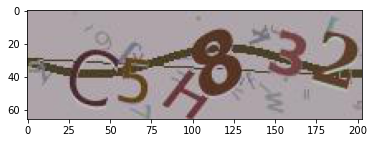

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 44, 140])


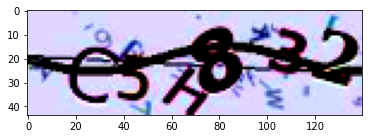

In [7]:
for i in range(1):
    image = Image.open(image_paths[i])
    plt.imshow(image)
    plt.show()
    
    preprocess = transforms.Compose([
            transforms.Resize((44, 140)), 
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
        ])

    image_tensor = preprocess(image)
    print(image_tensor.shape)
    plt.imshow(image_tensor.permute(1,2,0))
    plt.show()

### Generator

In [8]:
captcha_dataset = CaptchaDataset(base_path, target_size=(44,140))
dataloader = torch.utils.data.DataLoader(captcha_dataset,batch_size=64, shuffle=True,)

In [9]:
for i, (imgs, label) in enumerate(dataloader):
    print(imgs.shape)
#     print(label)
    
    break

torch.Size([64, 3, 44, 140])


In [10]:
generator = Generator(3)


In [31]:
class Discriminator(nn.Module):
    def __init__(self, num_channel=3):
        super(Discriminator, self).__init__()

        self.conv_layer = nn.Sequential(
            *conv_block(num_channel, 8, kernel_size=3, stride=2, padding=0, normalize="batch", activation="leakyrelu", alpha=0.2),
#             nn.MaxPool2d(2),
            *conv_block(8, 16, kernel_size=3, stride=2, padding=0, normalize="batch", activation="leakyrelu", alpha=0.2),
            # nn.MaxPool2d(2),
            *conv_block(16, 32, kernel_size=3, stride=2, padding=0, normalize="batch", activation="leakyrelu", alpha=0.2),
            # nn.MaxPool2d(2),
            # to reduce channel from 32 to 1
            *conv_block(32, 1, kernel_size=1, stride=1, padding=0, normalize=None, activation=None)
        )
        
        self.fc_layer = nn.Sequential(
            *fc_block(64, 1, normalize=None, activation="sigmoid", dropout=0.2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [32]:
discriminator = Discriminator()
print(discriminator)

x = discriminator(imgs)
x.shape

Discriminator(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Sigmoid()
  )
)


torch.Size([64, 1])

In [12]:
fake_imgs = generator(imgs).detach()
fake_imgs.shape

torch.Size([64, 3, 44, 140])

In [19]:
img_shape = (3, 44, 140)

z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], *img_shape))))

In [20]:
z.shape

torch.Size([64, 3, 44, 140])